In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
from lens import bessel
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.special import jn
from ht import intht

[ 0.0907669   0.06505236  0.05630144  0.04188994]


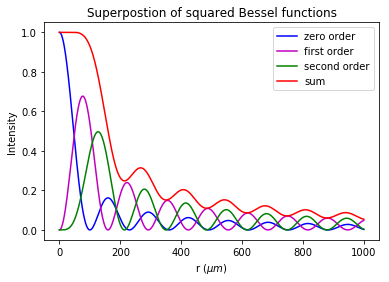

In [2]:
# First we need to expand the cross section in Bessel functions
# Time delay means we effectively add intensity so Absolute value of Bessel functions
# (Technically we multiply ionization fractions but this should give us a good first pass)
# Start by assuming all of the Bessel functions have the same center frequency

R = 0.1e3 # Radius to the first zero of the Bessel
r = np.linspace(0, 1e3, 1000, False)
kr0 = 2.4048 / R
I = np.zeros(1000)
I[r < 0.2e3] = 1.0
# Coefficents on the different Bessel functions
# Integration doesn't work beacuse Bessel functions of the same frequency are not orthogonal
cn = np.zeros(4)
for i in range(0, 4):
    cn[i] = integrate.simps(I * abs(jn(i, kr0*r)), r)/1000
print(cn)
cn = [1., 2.0, 2.1, 0]
Itest = cn[0]*jn(0, kr0*r)**2 + cn[1]*jn(1, kr0*r)**2 + cn[2]*jn(2, kr0*r)**2 + cn[3]*jn(3, kr0*r)**2
plt.plot(r, jn(0, kr0*r)**2, 'b-', r, cn[1]*jn(1, kr0*r)**2, 'm-', r, cn[2]*jn(2, kr0*r)**2, 'g-',r, Itest, 'r')
plt.title('Superpostion of squared Bessel functions')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'Intensity')
plt.legend(['zero order', 'first order', 'second order', 'sum'])
plt.show()
# Maybe the first 3 could give us about 400um diameter pulse

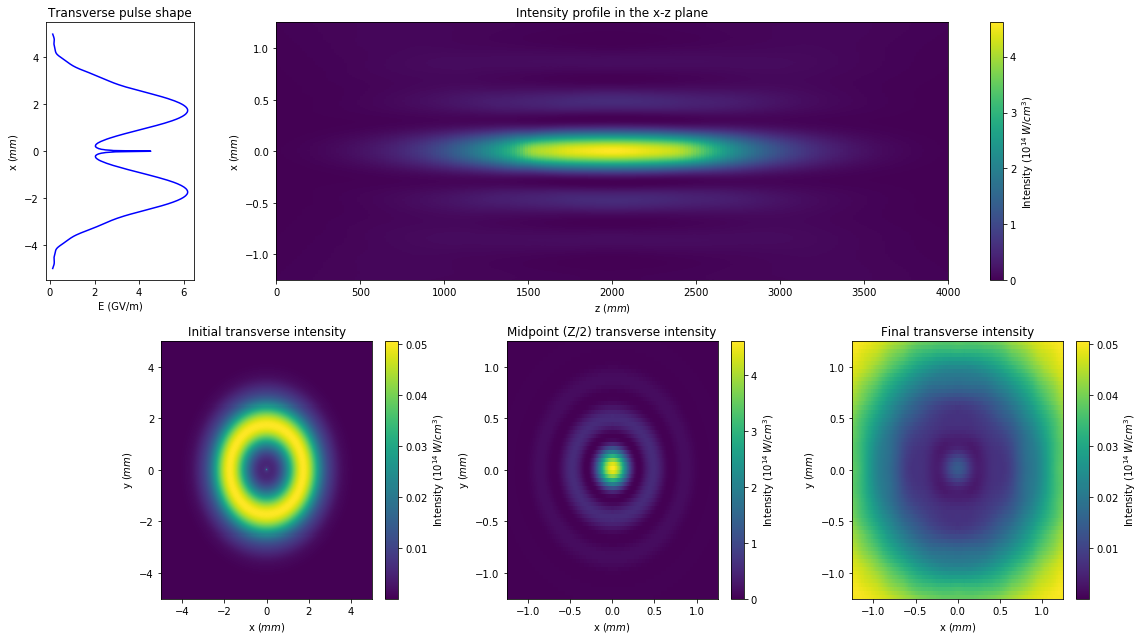

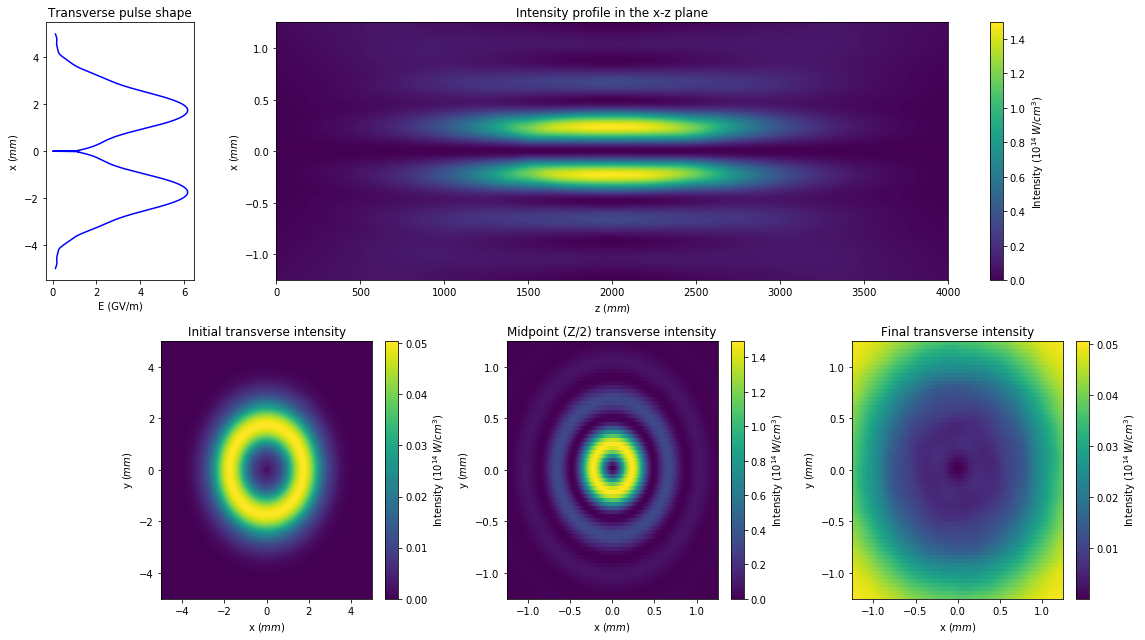

In [3]:
# First lets work with the two zone axilens and see how it works.
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

params = {'N' : 5000,
          'M' : 5000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
rm0, E0 = bessel.uniform_bessel(params, Ez, z, 0)
E0 = E0*8.15e6

params = {'N' : 5000,
          'M' : 5000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
rm1, E1 = bessel.uniform_bessel(params, Ez, z, 1)
E1 = E1*8.15e6

Efield0 = interp1d(rm0, E0)
Efield1 = interp1d(rm1, E1)
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    phi = np.zeros(np.shape(r))
    phi[int(params['Nx']/2), int(params['Ny']/2):] = np.pi/2
    phi[int(params['Nx']/2), :int(params['Ny']/2)] = -np.pi/2
    sel = np.array(x > 0)
    xp = x[sel]
    xp = np.reshape(xp, (np.size(xp), 1))
    phi[int(params['Nx']/2+1):, :] = np.arctan(y/xp)
    sel = np.array(x < 0)
    xn = x[sel]
    xn = np.reshape(xn, (np.size(xn), 1))
    phi[:int(params['Nx']/2), :] = np.arctan(y/xn) + np.pi
    E0 = Efield(r) * np.exp(1j*params['order']*phi)
    return E0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : 0.8,
          'n' : 1.0,
          'Efield' : Efield0,
          'order' : 0
          }

path = '/media/robert/Data_Storage/Data/Optics/TwoZoneAxilens/'
directory = 'Zero_Order_Bessel'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

params['Efield'] = Efield1
params['order'] = 1
directory = 'First_Order_Bessel'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

In [4]:
# Now we figure out the total plasma density
Efield0 = np.load(path+'Zero_Order_Bessel/'+'electricField.npy')
Efield1 = np.load(path+'First_Order_Bessel/'+'electricField.npy')
atom = ionization.H2

Efield0 = 1.*Efield0
Efield1 = 1.8*Efield1
# Calulate the ionization fraction from each piece of the pulse
frac0 = adk.gaussian_frac(atom['EI'], abs(Efield0), ion['tau'], atom['Z'], atom['l'], atom['m'])
frac1 = adk.gaussian_frac(atom['EI'], abs(Efield1), ion['tau'], atom['Z'], atom['l'], atom['m'])

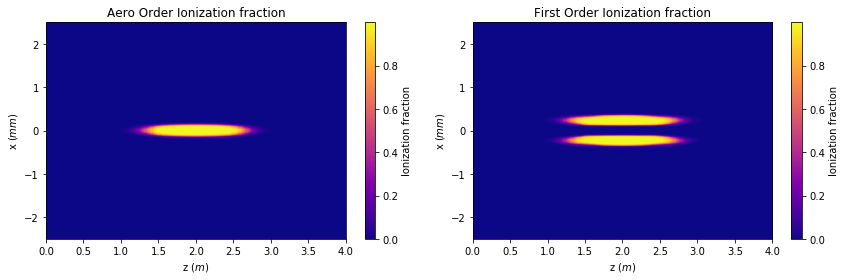

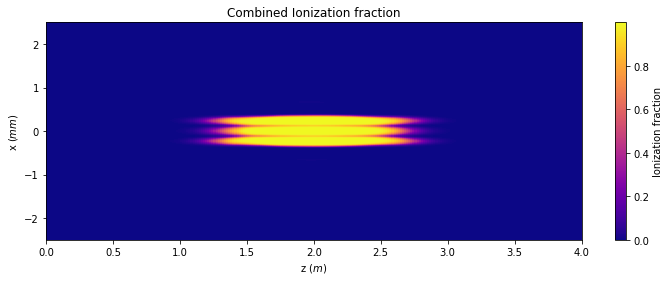

In [5]:
X = params['X']
Z = params['Z']
Ny = params['Ny']

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(np.flipud(np.transpose(frac0[:, :, int(Ny/2)])),
           aspect='auto',
           extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.set_cmap('plasma')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('Aero Order Ionization fraction')
plt.xlim([0, Z/1e6])
plt.ylim([-X/4e3, X/4e3])

plt.subplot(122)
plt.imshow(np.flipud(np.transpose(frac1[:, :, int(Ny/2)])),
           aspect='auto',
           extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.set_cmap('plasma')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('First Order Ionization fraction')
plt.xlim([0, Z/1e6])
plt.ylim([-X/4e3, X/4e3])

plt.tight_layout()
plt.show()

# Find the total ionization amount
frac = frac0 + (1-frac0)*frac1

plt.figure(figsize=(12,4))
plt.imshow(np.flipud(np.transpose(frac[:, :, int(Ny/2)])),
           aspect='auto',
           extent=[0, Z/1e6, -X/2e3, X/2e3])
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.set_cmap('plasma')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('Combined Ionization fraction')
plt.xlim([0, Z/1e6])
plt.ylim([-X/4e3, X/4e3])
plt.show()

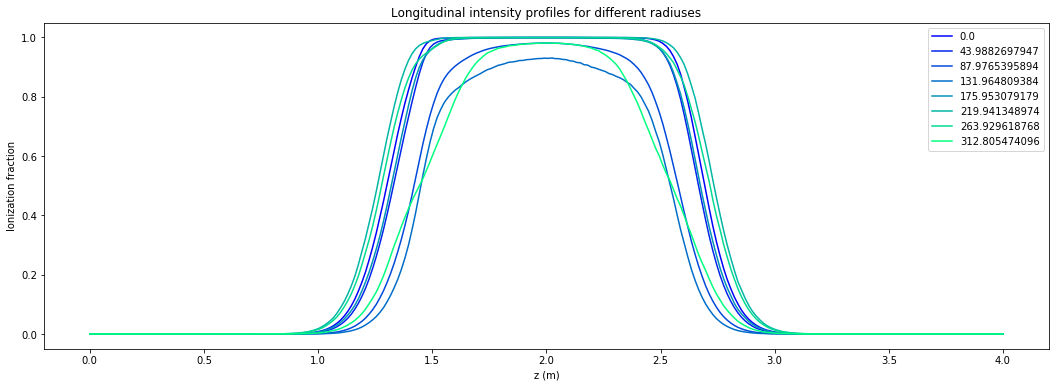

In [12]:
# Plot intensity profiles
Nx = params['Nx']
Nz = params['Nz']
z = np.linspace(0, Z, Nz)

H = 8
sliceInd = np.linspace(Nx/2, Nx/2+Nx/32, H, dtype=np.int)
dx = X/(Nx-2)
slicePosition = (sliceInd-1)*dx - X/2

plt.figure(figsize=(18, 6))
ax = plt.axes()
ax.set_prop_cycle('color', [plt.cm.winter(i) for i in np.linspace(0, 1, H)])
for i in range(0, H):
    plt.plot(z/1e6, frac[:, sliceInd[i], int(Ny/2)])
    
plt.title('Longitudinal intensity profiles for different radiuses')
plt.xlabel('z (m)')
plt.ylabel('Ionization fraction')
plt.legend(slicePosition)
plt.show()